In [6]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/home/kirill/code2seq/code_blocks_final_clean.csv')

In [9]:
COMM_COLUMN = 'tag'

In [10]:
df = df.dropna(subset=[COMM_COLUMN]).reset_index()

In [12]:
df = df.drop(columns=['index', 'Unnamed: 0'], axis=1)

In [13]:
def wordListToFreqDict(wordlist):
    def sortFreqDict(freqdict):
        aux = [(freqdict[key], key) for key in freqdict]
        aux.sort()
        aux.reverse()
        return aux
    wordfreq = [wordlist.count(p) for p in wordlist]
    return sortFreqDict(dict(list(zip(wordlist,wordfreq))))

In [17]:
def tokens_search(df, tokens, new_column_name):
    df[new_column_name] = 0
    for i in range(len(df)):
        percents = str(round(100*i/len(df),1))
        print(percents + '%\r', end='')
        row = df[COMM_COLUMN][i]
        for token in tokens:
            result = re.search(token, row, re.IGNORECASE)
            if result!=None:
                df[new_column_name][i] = 1
                break
    return df

### Выборка для регулярных выражений


In [19]:
graph = {'imports':['import', 'from', 'libr']#, 'as']
          ,'load_data':['load', 'csv', 'glob', 'pickle', 'read', 'txt']
          ,'visualize':['visual', 'plot', 'figure', 'draw',  'histogram', 'diagram', 'chart']
          ,'preprocessing':['ohe','miss', 'eda', 'preprocess', 'encode', 'fill', 'merge', 'vectorize', 'gener', 'augment', 'stemm', 'lemmat', 'scal', 'normali', 'crop', 'convert', 'resize']
          ,'model':['build', 'LinearRegression', 'RandomForest', 'Ridge', 'Lasso', 'SGD', 'LogisticRegression', 'SVM', 'SVC', 'Layer', 'xgboost', 'LGBM', 'CatBoost']
          ,'train': ['teach', 'train', 'fit', 'epoch', 'loss', 'learn', 'optimizer',]
          ,'predict':['score', 'predict', 'error', 'evaluation', 'MSE', 'test', 'accuracy']
}

In [82]:
for i in range(0, len(graph)):
    vertice = list(graph.keys())[i]
    print(vertice, i)
    tokens = graph[vertice]
    df = tokens_search(df, tokens, vertice)

### TF-IDF и  логичтическая регрессия

In [25]:
corpus = df['code_block']
train_corpus = df['code_block'][0:80000]
test_corpus = df['code_block'][80000:]

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=5
                        , max_df = 0.3
                        , ngram_range = (1,2)
                        , smooth_idf = True
                       )
features = tfidf.fit_transform(corpus)

In [27]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(features[0:len(df['preprocessing'])], df['preprocessing'], test_size=0.25)
clf = LogisticRegression(random_state=4321, n_jobs=-1).fit(X_train, y_train, )
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)

CPU times: user 99.6 ms, sys: 190 ms, total: 289 ms
Wall time: 6.98 s


In [28]:
y_pred = clf.predict(X_test)
print(f'F1-score {round(metrics.f1_score(y_test, y_pred)*100, 2)}%')

prec, rec, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba[:, 1])
print('pr-auc=', round(metrics.auc(rec, prec), 2))

F1-score 49.33%
pr-auc= 0.64


In [29]:
y_pred.sum(), y_pred.shape[0]

(4180, 26832)

In [30]:
y_pred = np.random.uniform(size=X_test.shape[0])
y_pred = (y_pred > 0.5) * 1

print(f'F1-score {round(metrics.f1_score(y_test, y_pred)*100, 2)}%')

prec, rec, thresholds = metrics.precision_recall_curve(y_test, y_pred)
print('pr-auc=', round(metrics.auc(rec, prec), 2))

F1-score 37.78%
pr-auc= 0.48


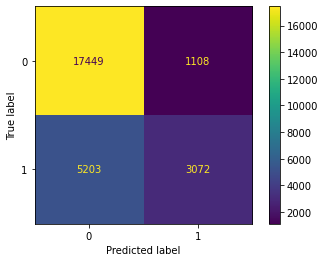

In [31]:
metrics.plot_confusion_matrix(clf, X_test, y_test, values_format='d')

Теперь посмотрим на результаты на валиадационной выборке:

In [63]:
validation = pd.read_csv('/home/kirill/Desktop/all_google_sheet.csv')
validation = validation[validation['Code'].isna() != True]

In [64]:
validation = validation.reset_index().drop(columns=['index'], axis=1)


In [65]:
to_del = []
for i in range(validation.shape[0]):
    if 'def' in validation.loc[i]['Code']:
        to_del.append(i)

validation = validation.drop(index=to_del, axis=1)
validation = validation.reset_index().drop(columns=['index'], axis=1)
validation = validation['Code']

In [67]:
val_tfidf = tfidf.transform(validation)

In [68]:
y_pred = clf.predict(val_tfidf)
y_test = (np.zeros_like(y_pred) == 0) * 1
print(f'F1-score {round(metrics.f1_score(y_pred, y_test)*100, 2)}%')

prec, rec, thresholds = metrics.precision_recall_curve(y_pred, y_test)
print('pr-auc=', round(metrics.auc(rec, prec), 2))
y_pred.sum(), y_pred.shape[0]

F1-score 74.75%
pr-auc= 0.8


(111, 186)

In [75]:
precision = 1
recall = (111)/ (186)
'f1', 2*precision*recall / (precision + recall)

('f1', 0.7474747474747475)

### Предсказания модели code2vec

In [ ]:
f = open('/home/kirill/code2vec/last_pred.txt', 'r')
lines = f.readlines()

In [ ]:
corr_ans = 0
for line in lines:
    if line[25] == 'p':
        corr_ans += 1

corr_ans, len(lines)

Полученные результаты для валидационного датасета:

In [84]:
precision = 1
recall = (56+17)/ (86+90)
'f1', 2*precision*recall / (precision + recall)

('f1', 0.5863453815261045)